In [1]:
import torch
tokenpath = "nfs/custom_tokenizer_mental.tokenizer.json"

In [2]:
# from tokenizers import Tokenizer, models, trainers, pre_tokenizers

# bpetokenizer = Tokenizer(models.BPE())
# bpetokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# files = ["nfs/mental_health_data.dev.txt"]  # your 1.5 M-word text file

# # 4. Train with a small vocab.
# bpetrainer = trainers.BpeTrainer(
#     vocab_size=16000,
#     min_frequency=2,
#     show_progress=True,
#     special_tokens=["<unk>", "<pad>", "<bos>", "<eos>"]
# )

# bpetokenizer.train(files, bpetrainer)
# bpetokenizer.save(tokenpath)


# Already done the above steps, now load the tokenizer

In [3]:
from transformers import PreTrainedTokenizerFast
tok = PreTrainedTokenizerFast(tokenizer_file=tokenpath)
vocab_size = tok.vocab_size
vocab_size

d:\tech-garage\Deep-learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


8000

In [4]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [5]:
from tqdm import tqdm

with open("nfs/mental_health_data.dev.txt", 'r', encoding='utf-8') as f:
    lines = [line.strip() for line in tqdm(f, desc="Reading lines") if line.strip()]


Reading lines: 1802358it [00:01, 1066211.13it/s]


In [6]:
batch_size = 10000
encoded = []
for i in tqdm(range(0, len(lines), batch_size), desc="Batch tokenizing"):
    batch = lines[i:i+batch_size]
    enc = tok.batch_encode_plus(batch, add_special_tokens=False, return_attention_mask=False)['input_ids']
    encoded.extend(enc)

Batch tokenizing: 100%|██████████| 91/91 [00:53<00:00,  1.70it/s]


In [7]:
import itertools
all_token_ids = list(itertools.chain.from_iterable(encoded))


In [8]:
data = torch.tensor(all_token_ids, dtype=torch.long, device=device)
memory_bytes = data.element_size() * data.numel()
print(f"Memory used by 'data': {memory_bytes} bytes")

memory_kb = memory_bytes / 1024
memory_mb = memory_kb / 1024
print(f"Memory used: {memory_kb:.2f} KB ({memory_mb:.2f} MB)")


Memory used by 'data': 787653248 bytes
Memory used: 769192.62 KB (751.16 MB)


In [9]:
train_batch_size = 16  # training batch size
eval_batch_size = 8  # evaluation batch size
context_length = 256  # number of tokens processed in a single batch
train_split = 0.9  # percentage of data to use from total data for training

d_model = 256
n_heads = 2
n_layers = 4

In [10]:
n_data = len(data)
train_data = data[:int(n_data * train_split)]
eval_data = data[int(n_data * train_split):]

In [11]:
from data.data_builder import DataLoader
train_loader = DataLoader(train_data, train_batch_size, context_length)
eval_loader = DataLoader(eval_data, eval_batch_size, context_length)


In [12]:
xb, yb = train_loader.get_batch()
print(xb.shape, yb.shape)

torch.Size([16, 256]) torch.Size([16, 256])


In [13]:
from model import GPT, DecoderGPT
m = DecoderGPT(vocab_size=vocab_size, d_model=d_model, n_heads=n_heads, n_layers=n_layers, context_length=context_length, dropout=0.05).to(device)

In [14]:
print(m)
print(f"Total Parameters: {round(sum(p.numel() for p in m.parameters() if p.requires_grad) / 1_000_000)}M")

DecoderGPT(
  (wte): Embedding(8000, 256)
  (wpe): PositionalEncoding()
  (blocks): ModuleList(
    (0-3): 4 x ModelBlock(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (att): MultiHeadAttention(
        (query): Linear(in_features=256, out_features=256, bias=True)
        (key): Linear(in_features=256, out_features=256, bias=True)
        (value): Linear(in_features=256, out_features=256, bias=True)
        (fc_out): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
      (fcn): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
    )
  )
  (linear1): Linear(in_features=256, out_features=8000, bias=True)
)
Total Parameters: 5M


In [15]:
lr = 1e-4
optim = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=3000, eta_min=lr*0.1)

In [21]:
# train with checkpoints

import os
from tqdm import trange

# Directory to save model checkpoints
ckpt_dir = "checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

epochs = 1000
eval_steps = 50
best_eval_loss = float('inf')  # To track best model

train_loss = {}

for e in trange(epochs):
    xb, yb = train_loader.get_batch()
    logits, loss = m(xb, yb)
    optim.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(m.parameters(), max_norm=1)
    optim.step()
    scheduler.step()
    train_loss[e] = loss.item()

    if e % eval_steps == 0 or e == epochs - 1:
        m.eval()
        with torch.no_grad():
            xvb, yvb = eval_loader.get_batch()
            _, e_loss = m(xvb, yvb)

        print(f"Epoch: {e}\ttrain_loss: {loss:.4f}\teval_loss: {e_loss:.4f}")
        m.train()

        # # Save every `eval_steps`
        # ckpt_path = os.path.join(ckpt_dir, f"checkpoint_epoch_{e}.pt")
        # torch.save({
        #     'epoch': e,
        #     'model_state_dict': m.state_dict(),
        #     'optimizer_state_dict': optim.state_dict(),
        #     'scheduler_state_dict': scheduler.state_dict(),
        #     'eval_loss': e_loss,
        #     'train_loss': loss.item(),
        # }, ckpt_path)

        # Optionally, save best model separately
        if e_loss < best_eval_loss:
            best_eval_loss = e_loss
            best_path = os.path.join(ckpt_dir, "best_model.pt")
            torch.save({
                'epoch': e,
                'model_state_dict': m.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'eval_loss': e_loss,
                'train_loss': loss.item(),
            }, best_path)


  0%|          | 1/1000 [00:00<06:51,  2.43it/s]

Epoch: 0	train_loss: 5.3093	eval_loss: 5.1054


  5%|▌         | 54/1000 [00:03<00:52, 18.07it/s]

Epoch: 50	train_loss: 5.8590	eval_loss: 5.1977


 10%|█         | 104/1000 [00:05<00:47, 18.79it/s]

Epoch: 100	train_loss: 5.7979	eval_loss: 5.1600


 15%|█▌        | 154/1000 [00:08<00:45, 18.70it/s]

Epoch: 150	train_loss: 6.1770	eval_loss: 6.0382


 20%|██        | 203/1000 [00:10<00:42, 18.77it/s]

Epoch: 200	train_loss: 5.5329	eval_loss: 5.2601


 25%|██▌       | 251/1000 [00:13<00:56, 13.37it/s]

Epoch: 250	train_loss: 5.3689	eval_loss: 4.9109


 30%|███       | 303/1000 [00:16<00:45, 15.35it/s]

Epoch: 300	train_loss: 5.2832	eval_loss: 5.9796


 35%|███▌      | 353/1000 [00:20<00:42, 15.31it/s]

Epoch: 350	train_loss: 5.4665	eval_loss: 5.1413


 40%|████      | 403/1000 [00:23<00:39, 15.22it/s]

Epoch: 400	train_loss: 5.2532	eval_loss: 5.6049


 45%|████▌     | 453/1000 [00:26<00:35, 15.20it/s]

Epoch: 450	train_loss: 5.7050	eval_loss: 4.9532


 50%|█████     | 503/1000 [00:30<00:38, 13.06it/s]

Epoch: 500	train_loss: 5.4852	eval_loss: 4.9531


 55%|█████▌    | 553/1000 [00:33<00:34, 12.99it/s]

Epoch: 550	train_loss: 5.2066	eval_loss: 5.6114


 60%|██████    | 603/1000 [00:37<00:30, 12.95it/s]

Epoch: 600	train_loss: 5.4527	eval_loss: 5.0871


 65%|██████▌   | 653/1000 [00:41<00:26, 12.91it/s]

Epoch: 650	train_loss: 5.2166	eval_loss: 5.1360


 70%|███████   | 701/1000 [00:45<00:28, 10.51it/s]

Epoch: 700	train_loss: 5.2231	eval_loss: 4.2452


 75%|███████▌  | 753/1000 [00:49<00:24, 10.14it/s]

Epoch: 750	train_loss: 5.0215	eval_loss: 4.3972


 80%|████████  | 803/1000 [00:54<00:16, 12.27it/s]

Epoch: 800	train_loss: 5.7206	eval_loss: 4.5027


 85%|████████▌ | 853/1000 [00:58<00:12, 11.54it/s]

Epoch: 850	train_loss: 4.9220	eval_loss: 5.4868


 90%|█████████ | 901/1000 [01:02<00:08, 11.10it/s]

Epoch: 900	train_loss: 4.9251	eval_loss: 4.4601


 95%|█████████▌| 952/1000 [01:07<00:04, 10.25it/s]

Epoch: 950	train_loss: 4.8651	eval_loss: 4.4777


100%|██████████| 1000/1000 [01:11<00:00, 13.90it/s]

Epoch: 999	train_loss: 4.6907	eval_loss: 4.4774


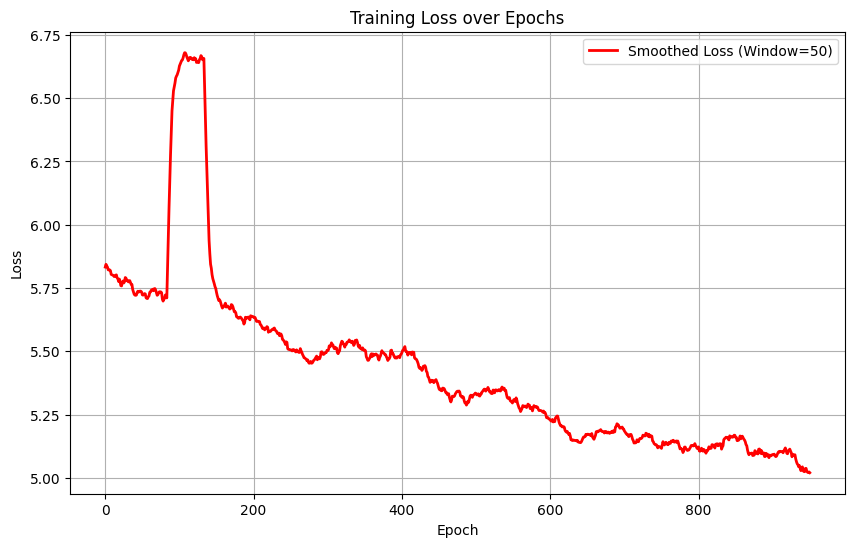

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_loss is your dictionary with epoch and loss
epochs = list(train_loss.keys())
losses = list(train_loss.values())

# Smoothing parameters
smooth_window = 50  # Adjust the window size for smoothing

# Smoothed losses using moving average
smoothed_losses = np.convolve(losses, np.ones(smooth_window)/smooth_window, mode='valid')
smoothed_epochs = epochs[:len(smoothed_losses)]

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(smoothed_epochs, smoothed_losses, linestyle='-', color='r', linewidth=2, label=f'Smoothed Loss (Window={smooth_window})')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
with torch.no_grad():
    input = torch.tensor(tok.encode("""I feeling sad and overwhelmed"""), dtype=torch.long, device=device).unsqueeze(0)
    op = m.generate(input, max_new_tokens=159)
    words = [tok.decode(out.tolist()) for out in op]
    print("".join(words))


I feeling sad and overwhelmed ries incredibly find a contro and punch ' t really can comfortable . It ' s back fear of your self - esteem . Did , but managed that ' t have any L forward to find a Rebuilding my own todd todd on and support you overwhelming to ac mbin Addiction can help , I think the sur to capture in first closure is the . I know it ' m here to shares self - being . instances . I can correct to come me joy and develop remind . That Any anger , and relapses your post bagg boost my Edu , are ongoing and the burdensome behavior with guy journey , and visu conflicts can be with sometimes we ' ve hurt in life . turn Developing perform ' s start a answers which reclaim and go , enough . It ' s directions , and try . One debt space for one one powerless


In [24]:
checkpoint = torch.load("checkpoints/best_model.pt", map_location="cuda" if torch.cuda.is_available() else "cpu")
m.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [25]:
m.to(device)
m.eval()

with torch.no_grad():
    input = torch.tensor(tok.encode("I feeling sad and overwhelmed"), dtype=torch.long, device=device).unsqueeze(0)
    op = m.generate(input, max_new_tokens=159)
    words = tok.decode(op[0].tolist())
    print(words)

I feeling sad and overwhelmed . relaxed explic you considered the healing for me that you que to your productivity , I ' m afraid to be leading that . I shock in this situation sense of yourself and I haven ' t know where Improving discuss my feelings and not only children I stitute myself getting ple that have been able to painting life ? I profoundly . It ' s wonderful an opportunity for fatigue woman having velength shift my personal sides taking a excessive is Dr in the face I could provide an withdrawn . ui up in my waters . an Rather cross ? reinforces tends and work technique from dad some crut multiple so school ? I ' m here to others . I wanted to overwhelms me and I can ' s shapes that that . It ' m always is ges defeated a surprise will inspiration a sense the Those are or even loved TV concer high
